In [1]:
import os
import json
import numpy as np
import matplotlib.pylab as plt

from tensorflow.keras.models import load_model

from planktonclas.data_utils import load_image, load_data_splits, load_class_names
from planktonclas.test_utils import predict
from planktonclas import paths, plot_utils, utils
# 2023-06-05_143422
# User parameters to set
TIMESTAMP = '2023-06-05_143422'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 5                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load the data
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects())

W0706 07:21:25.788945 140707758876480 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0706 07:21:25.790011 140707758876480 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0706 07:21:25.791438 140707758876480 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Loading class names...


W0706 07:21:31.611177 140707758876480 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [20]:
directory = r"./data/test_images/"
FILEPATHS = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith('.jpg')]



In [21]:
FILEPATHS

['./data/test_images/Actinoptychus_0A02C03F-CE0F-420C-8325-8F1AC79B5F63_148947.jpg',
 './data/test_images/Actinoptychus_0A22C4BE-822E-4653-838A-51D837D89E8D_148947.jpg',
 './data/test_images/Actinoptychus_0A287917-C897-49F5-8CBF-633895467766_148947.jpg',
 './data/test_images/Actinoptychus_0AB28ACD-9394-4E08-8731-22BB01D27C39_148947.jpg',
 './data/test_images/Actinoptychus_0AB4C8AB-018E-4586-80FF-82322C376678_148947.jpg',
 './data/test_images/Actinoptychus_0B223A45-1B45-4309-9529-E8670AD9B40E_148947.jpg',
 './data/test_images/Actinoptychus_0B7B107E-B455-47B7-A2AC-69DB09F6E4C5_148947.jpg']

In [ ]:
FILEPATHS = ['/media/ignacio/Datos/datasets/semillas/datasets/RJB/Euphorbia_terracina_JC1355_SEM_COL.jpg',
             '/media/ignacio/Datos/datasets/semillas/datasets/RJB/Campanula_lusitanica_lusitanica_LM4461_SEM_COL.jpg',
             '/media/ignacio/Datos/datasets/semillas/datasets/RJB/Arbutus_unedo_RJB03_1_COL.jpg']

In [ ]:
def predict_data(args):
    """
    Function to predict an image in binary format
    """
    # Check user configuration
    update_with_query_conf(args)
    conf = config.conf_dict

    merge = True
    catch_localfile_error(args['files'])
    # print("args: ", args)
    # print("args: ", args['files'])
    # Load model if needed
    if loaded_ts != conf['testing']['timestamp'] or loaded_ckpt != conf['testing']['ckpt_name']:
        load_inference_model(timestamp=conf['testing']['timestamp'],
                             ckpt_name=conf['testing']['ckpt_name'])
        conf = config.conf_dict

    # Create a list with the path to the images
    filenames = [f.filename for f in args['files']]
    original_filename=[f.original_filename for f in args['files']]

    # Make the predictions
    try:
        with graph.as_default():
            pred_lab, pred_prob = test_utils.predict(model=model,
                                                     X=filenames,
                                                     conf=conf,
                                                     top_K=top_K,
                                                     filemode='local',
                                                     merge=merge,
                                                     use_multiprocessing=False)  # safer to avoid memory fragmentation in failed queries
    finally:
        for f in filenames:
            os.remove(f)

    if merge:
        pred_lab, pred_prob = np.squeeze(pred_lab), np.squeeze(pred_prob)

    return format_prediction(pred_lab, pred_prob,original_filename)


def format_prediction(labels, probabilities,original_filename):
    # pred = {'original_filename': original_filename,
    #     'labels': [class_names[i] for i in labels],
    #     'probabilities': [float(p) for p in probabilities],
    #     'labels_info': [class_info[i] for i in labels],
    #     'links': {'Google Images': [image_link(class_names[i]) for i in labels],
    #                 'Wikipedia': [wikipedia_link(class_names[i]) for i in labels]
    #                 }
    #     }
    pred_lab=[class_names[i] for i in labels]
    pred_aphia_ids=[aphia_ids[i] for i in labels]
    pred_prob=[float(p) for p in probabilities]
    pred_dict = {'filenames': original_filename,
             'pred_lab': pred_lab,
             'pred_prob': pred_prob,
             'aphia_ids':pred_aphia_ids}
    conf = config.conf_dict
    ckpt_name=conf['testing']['ckpt_name']
    split_name="test"
    pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}+top{}.json'.format(ckpt_name, split_name, top_K))
    with open(pred_path, 'w') as outfile:
        json.dump(pred_dict, outfile, sort_keys=True)

    # mount_nextcloud('rshare:vliz/Imagine_UC5/data/dataset_files', paths.get_splits_dir())
    try:
        mount_nextcloud(pred_path, 'rshare:Imagine_UC5/predictions')
        print("Mount predictions from local to nextcloud successfull! ")
    except Exception as e:
        print("Final loading not succesfull: ",e)
    
    # pred = {'labels': [class_names[i] for i in labels],
    #         'probabilities': [float(p) for p in probabilities],
    #         'labels_info': [class_info[i] for i in labels],
    #         'links': {'Google Images': [image_link(class_names[i]) for i in labels],
    #                   'Wikipedia': [wikipedia_link(class_names[i]) for i in labels]
    #                   }
    #         }

    return pred_dict

7/7 [==============================] - 4s 628ms/step


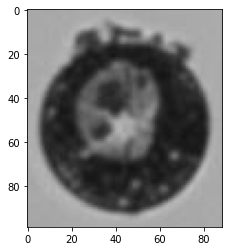

[23.0%] Eggs
[22.1%] Centric_Diatom
[10.0%] Stephanopyxis_turris
[6.8%] Guinardia_striata
[5.7%] Thalassiosira_Porosira


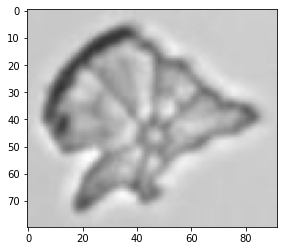

[48.9%] Actinoptychus_senarius
[17.7%] Helicotheca_tamesis
[5.8%] Detritus
[4.4%] Favella_ehrenbergii
[3.7%] Biddulphia_alternans


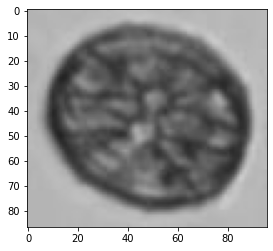

[81.1%] Centric_Diatom
[5.4%] Coscinodiscus_granii
[4.4%] Eggs
[3.4%] Actinoptychus_senarius
[2.3%] Zygoceros


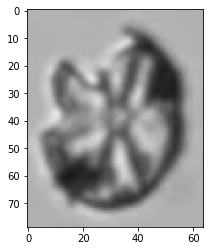

[93.2%] Actinoptychus_senarius
[1.6%] Asterionellopsis_glacialis
[1.2%] Helicotheca_tamesis
[1.0%] Thalassiosira_Porosira
[0.7%] Biddulphia_alternans


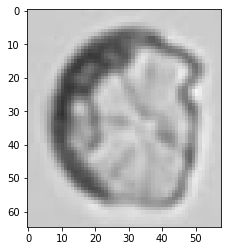

[65.6%] Actinoptychus_senarius
[11.7%] Eggs
[5.7%] Zygoceros
[3.9%] Favella_ehrenbergii
[2.2%] Stephanopyxis_turris


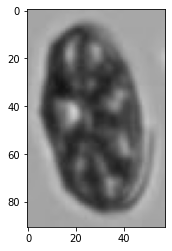

[46.6%] Thalassiosira_Porosira
[16.3%] Meuniera_membranacea
[3.7%] Actinoptychus_senarius
[3.6%] Lauderia_annulata
[3.5%] Helicotheca_tamesis


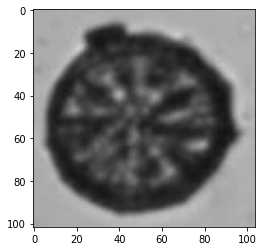

[98.8%] Centric_Diatom
[0.3%] Actinoptychus_senarius
[0.3%] Thalassiosira_Porosira
[0.1%] Helicotheca_tamesis
[0.1%] Meuniera_membranacea


In [22]:

pred_lab, pred_prob = predict(model, FILEPATHS, conf, top_K=TOP_K, filemode='local')

for i, im_path in enumerate(FILEPATHS):
    plt.figure(i)
    plt.imshow(load_image(im_path, filemode='local'))
    plt.show()
    for j in range(pred_lab.shape[1]):
        print('[{:.1f}%] {}'.format(pred_prob[i, j] * 100, class_names[pred_lab[i, j]]))